This notebook corrects for less intensity deeper in the sample by rescaling intensities relative to the maximum intensity in each sample.
To do so we must:
- Preserve the relativity of intensities between samples.
- Rescale loss of intensity in each sample relative to the maximum intensity in that sample.

I will use methods inspired by Ting et al. 2023. 
doi: https://doi.org/10.1101/2023.11.08.566158

Quoted from Ting et al. 2023:
"The acquired 3D images were subject to intensity decay along z direction, necessitating intensity enhancement, particularly in the later z slices. 
To perform histogram matching using `Skimage`, we calculated the 99th percentile intensity for each slice and selected the slice with the highest 99th percentile as the reference slice. 
Based on the reference slice, a histogram matching procedure was performed for all slices. 
This preprocessing was carried out for all channels."

I will be drawing inspiration from their methods but will ultimately fail to copy or replicate their methods, due to a lack of available code.

This notebook will be converted into a script run in parallel on an HPC cluster.

## Import libraries

In [1]:
import argparse
import pathlib
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import skimage.io as io
import tifffile
from skimage.exposure import match_histograms

## Define functions

In [2]:
def z_slice_histogram_matching(
    image, percentile: int = 99, return_df: bool = False
) -> Tuple[Tuple[np.ndarray, pd.DataFrame, pd.DataFrame], np.ndarray]:
    """
    This function performs histogram matching on the z-slices of a 3D image to the z-slice with the highest nth percentile pixel value.

    Parameters
    ----------
    image : np.ndarray
        Input 3D image. In the format of (z, y, x).
    percentile : int, optional
        The nth percentile pixel value to use for histogram matching, by default 99
    return_df : bool, optional
        A boolean indicating whether to return the dataframes containing the nth percentile pixel values of the original and normalized images, by default False

    Returns
    -------
    Tuple[Tuple[np.ndarray, pd.DataFrame, pd.DataFrame], np.ndarray]
        Depending on the value of return_df, the function returns a tuple containing the normalized image and the dataframes containing the nth percentile pixel values of the original and normalized images.
    """
    # get the nth percentile of the image for each slice
    original_image_nth_pixel_dict = {"slice": [], f"{percentile}_percentile_pix": []}
    # loop through each slice and get the nth percentile pixel value
    for slice in range(image.shape[0]):
        original_image_nth_pixel_dict["slice"].append(slice)
        original_image_nth_pixel_dict[f"{percentile}_percentile_pix"].append(
            pd.Series(image[slice, :, :].flatten()).quantile(percentile / 100)
        )
    original_image_nth_pixel_df = pd.DataFrame(original_image_nth_pixel_dict)

    # find the slice with the highest 99th percentile pixel value
    max_percentile_slice = original_image_nth_pixel_df.loc[
        original_image_nth_pixel_df[f"{percentile}_percentile_pix"].idxmax()
    ]
    max_percentile_slice = image[max_percentile_slice["slice"].astype(int), :, :]

    # perform histogram matching on all slices to the slice with the highest 99th percentile pixel value
    # new image to store the matched histogram slices
    new_image = np.zeros(image.shape)
    for slice in range(image.shape[0]):
        new_image[slice, :, :] = match_histograms(
            image[slice, :, :], max_percentile_slice, channel_axis=None
        )
    new_image = new_image.astype(np.uint16)

    # get the nth percentile of the normalized image for each slice
    original_image_nth_pixel_normalized_dict = {
        "slice": [],
        f"{percentile}_percentile_pix": [],
    }
    for slice in range(new_image.shape[0]):
        original_image_nth_pixel_normalized_dict["slice"].append(slice)
        original_image_nth_pixel_normalized_dict[f"{percentile}_percentile_pix"].append(
            pd.Series(new_image[slice, :, :].flatten()).quantile(percentile / 100)
        )
    original_image_nth_pixel_normalized_df = pd.DataFrame(
        original_image_nth_pixel_normalized_dict
    )

    if return_df:
        return (
            new_image,
            original_image_nth_pixel_df,
            original_image_nth_pixel_normalized_df,
        )
    else:
        return new_image


def plot_max_ortho_slices(
    image: np.ndarray,
    anisotropy: Tuple[int, None] = None,
    show_plot: bool = True,
    plot_output_path: Tuple[pathlib.Path, None] = None,
) -> None:
    """
    A function to plot the maximum intensity projection of an image along the x, y, and z axes.

    Parameters
    ----------
    image : np.ndarray
        A 3D numpy array representing an image.
        The dimensions of the array should be (z, y, x).
    anisotropy : Tuple[int, None], optional
        A tuple of two integers representing the anisotropy of the image in the x and y directions.
        The default is None.
    show_plot : bool, optional
        A boolean indicating whether to show the plot or not.
        The default is True.
    plot_output_path : pathlib.Path, optional
        A pathlib.Path object representing the path to save the plot.
        The default is None.

    Returns
    -------
    None
    """

    # check if anisotropy is provided
    if anisotropy:
        # copy each slice anisotropy_factor times
        anisotropy_corrected_image = np.zeros(
            [image.shape[0] * anisotropy, image.shape[1], image.shape[2]]
        )
        for slice in range(image.shape[0]):
            # copy the slice anisotropy_factor times and add to the new image
            for i in range(anisotropy):
                anisotropy_corrected_image[slice * anisotropy + i, :, :] = image[
                    slice, :, :
                ]
        image = anisotropy_corrected_image

    height_ratio = image.shape[2] / image.shape[0]
    width_ratio = image.shape[1] / image.shape[0]
    # Create a figure with a custom layout
    fig = plt.figure(figsize=(7, 5))
    gs = fig.add_gridspec(
        2, 2, width_ratios=[width_ratio, 1], height_ratios=[height_ratio, 1]
    )

    # Add subplots to the custom layout
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])

    # Plot the images
    ax1.imshow(image.max(axis=0), cmap="gray")
    # remove x ticks
    ax1.set_xticks([])

    # Plot YZ slice with Z on the bottom axis
    yz_slice = np.rot90(image.max(axis=2), k=3)  # Rotate the image 90 degrees
    ax2.imshow(yz_slice, cmap="gray")
    # remove y ticks
    ax2.set_yticks([])

    ax3.imshow(image.max(axis=1), cmap="gray")

    plt.subplots_adjust(wspace=-0.8)
    plt.tight_layout()

    if plot_output_path:
        try:
            plot_output_path.parent.mkdir(parents=True, exist_ok=True)
            plot_output_path.resolve(strict=True)
        except FileNotFoundError:
            pass
        plt.savefig(plot_output_path, bbox_inches="tight")

    if show_plot:

        plt.show()


def plot_z_slice_histograms(
    raw_percentile_df: pd.DataFrame,
    normalized_percentile_df: pd.DataFrame,
    percentile: int = 99,
    show_plot: bool = True,
    plot_output_path: Tuple[pathlib.Path, None] = None,
) -> None:
    """
    Plot the before and after histogram matching 99th percentile pixel values for each slice.

    Parameters
    ----------
    raw_percentile_df : pd.DataFrame
        A pandas DataFrame containing the 99th percentile pixel values of the original image.
    normalized_percentile_df : pd.DataFrame
        A pandas DataFrame containing the 99th percentile pixel values of the normalized image.
    percentile : int, optional
        Pencentile used for histogram matching, by default 99
    show_plot : bool, optional
        A boolean indicating whether to show the plot or not, by default True
    plot_output_path : Tuple[pathlib.Path, None], optional
        A pathlib.Path object representing the path to save the plot, by default None

    Returns
    -------
    None
    """
    # plot the 99th percentile of the image for each slice
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.barplot(data=raw_percentile_df, x="slice", y=f"{percentile}_percentile_pix")
    plt.title("Raw 99th percentile pixel value")
    plt.xlabel("Slice")
    plt.xticks(rotation=90)
    plt.ylabel("99th percentile pixel value")
    plt.subplot(1, 2, 2)
    sns.barplot(
        data=normalized_percentile_df, x="slice", y=f"{percentile}_percentile_pix"
    )
    plt.title("Normalized 99th percentile pixel value")
    plt.xlabel("Slice")
    plt.xticks(rotation=90)
    plt.ylabel("99th percentile normalized pixel value")
    plt.tight_layout()
    if plot_output_path:
        try:
            plot_output_path.parent.mkdir(parents=True, exist_ok=True)
            plot_output_path.resolve(strict=True)
        except FileNotFoundError:
            pass
        plt.savefig(plot_output_path)
    if show_plot:
        plt.show()

## Load arguments, vars, and paths

In [ ]:
# check if in a jupyter notebook
try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False

if not in_notebook:
    print("Running as script")
    # set up arg parser
    parser = argparse.ArgumentParser(description="Segment the nuclei of a tiff image")

    parser.add_argument(
        "--input_dir",
        type=str,
        help="Path to the input directory containing the tiff images",
    )

    args = parser.parse_args()
    path_containing_images = pathlib.Path(args.input_dir).resolve(strict=True)
    show_plots = False
else:
    print("Running in a notebook")
    path_containing_images = pathlib.Path(
        "../../data/z-stack_images/raw_z_input"
    ).resolve(strict=True)
    show_plots = True
    figures_output_path = pathlib.Path(
        f"../figures/{path_containing_images.stem}"
    ).resolve()
    figures_output_path.mkdir(parents=True, exist_ok=True)


images_output_path = pathlib.Path(
    f"../../data/normalized_z/{path_containing_images.stem}"
).resolve()
images_output_path.mkdir(parents=True, exist_ok=True)

Running in a notebook


In [4]:
image_extensions = {".tif", ".tiff"}
channel_names = ["405", "488", "555", "640", "TRANS"]
# make a dictionary that contains a list for each channel name
channel_images = {channel_name: {"filepath": []} for channel_name in channel_names}
channel_images

{'405': {'filepath': []},
 '488': {'filepath': []},
 '555': {'filepath': []},
 '640': {'filepath': []},
 'TRANS': {'filepath': []}}

In [5]:
# get the list of files and directories in the input directory
input_files = [x for x in path_containing_images.iterdir()]
# assert for no subdirectories
assert not any([x.is_dir() for x in input_files])
for key in channel_images.keys():
    channel_images[key]["filepath"] = [
        x for x in input_files if x.suffix in image_extensions and key in x.name
    ]
channel_images

{'405': {'filepath': [PosixPath('/home/lippincm/Documents/GFF_3D_organoid_profiling_pipeline/data/z-stack_images/raw_z_input/C6-1_405.tif')]},
 '488': {'filepath': [PosixPath('/home/lippincm/Documents/GFF_3D_organoid_profiling_pipeline/data/z-stack_images/raw_z_input/C6-1_488.tif')]},
 '555': {'filepath': [PosixPath('/home/lippincm/Documents/GFF_3D_organoid_profiling_pipeline/data/z-stack_images/raw_z_input/C6-1_555.tif')]},
 '640': {'filepath': [PosixPath('/home/lippincm/Documents/GFF_3D_organoid_profiling_pipeline/data/z-stack_images/raw_z_input/C6-1_640.tif')]},
 'TRANS': {'filepath': [PosixPath('/home/lippincm/Documents/GFF_3D_organoid_profiling_pipeline/data/z-stack_images/raw_z_input/C6-1_TRANS.tif')]}}

## Rescale the pixel intensity of each slice 

Processing channel: 405


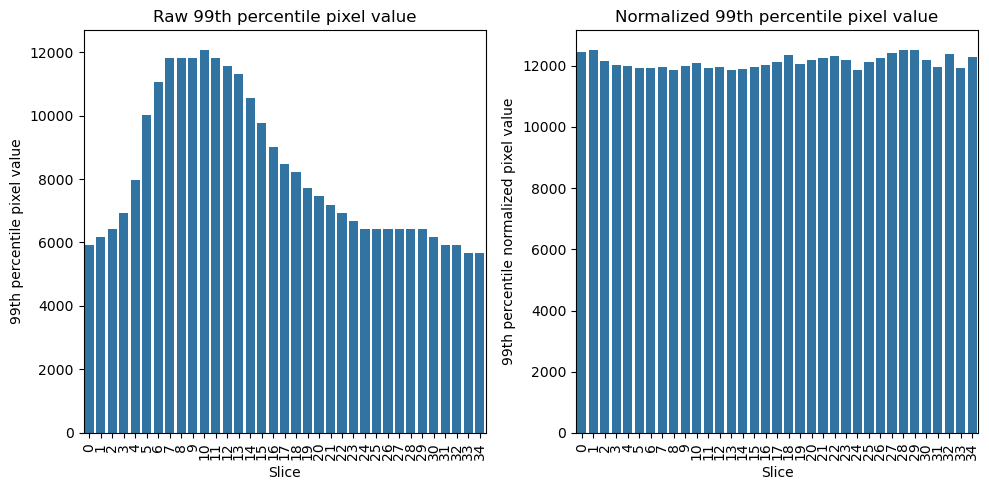

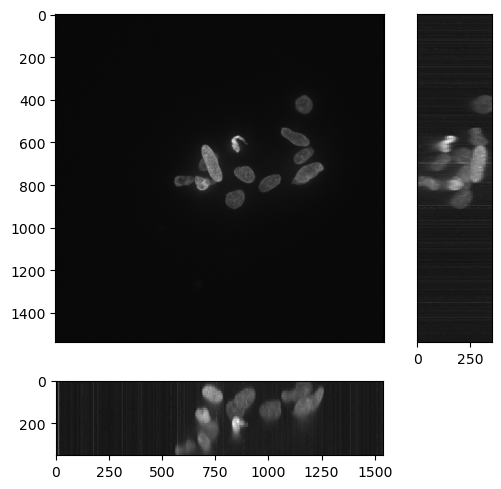

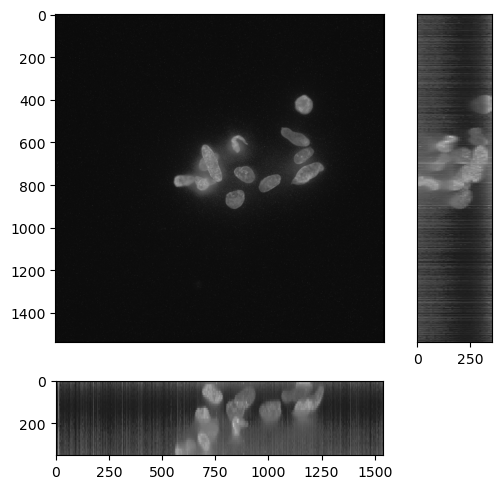

In [7]:
# set the percentile to 99
percentile = 99
# loop through each channel and process the images
for channel_name in channel_images.keys():
    print(f"Processing channel: {channel_name}")
    # get the first image in the list
    image = tifffile.imread(channel_images[channel_name]["filepath"][0])
    (
        new_image,
        ninenine_pecentile_df,
        ninenine_pecentile_normalized_df,
    ) = z_slice_histogram_matching(image, percentile=percentile, return_df=True)
    plot_z_slice_histograms(
        ninenine_pecentile_df,
        ninenine_pecentile_normalized_df,
        percentile=99,
        show_plot=show_plots,
        plot_output_path=None,
    )

    # set the path to output the plots if in a notebook
    if in_notebook:
        plot_output_path = pathlib.Path(
            figures_output_path / f"max_ortho_slices_{channel_name}.png"
        )
        plot_output_normalized_path = pathlib.Path(
            figures_output_path / f"max_ortho_slices_normalized_{channel_name}.png"
        )
    else:
        plot_output_path = None
        plot_output_normalized_path = None

    plot_max_ortho_slices(
        image=image,
        anisotropy=10,
        show_plot=show_plots,
        plot_output_path=plot_output_path,
    )

    plot_max_ortho_slices(
        image=new_image,
        anisotropy=10,
        show_plot=show_plots,
        plot_output_path=plot_output_normalized_path,
    )

    # save new image regardless of whether in notebook or not
    tifffile.imwrite(
        pathlib.Path(
            images_output_path
            / f"{channel_images[channel_name]['filepath'][0].stem}.tif"
        ),
        new_image,
    )